# DESAFIO 1 - GRUPO 4

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import re
import math
import missingno as mno
import geopandas as gpd
import re 
import matplotlib.pyplot as plt
import geopy.distance
from shapely.geometry import Point
import time
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns

#### 1. Carga de datos.

In [2]:
#Comenzamos leyendo el dataset
#df = pd.read_csv("properatti.csv")
df=pd.read_parquet("properatti.parquet")
df.drop(columns = "Unnamed: 0",inplace=True)

print("Vemos el tipo de datos que tiene nuestro dataframe")
print(df.info())
print("Nuestro dataframe original tiene", df.shape[0], " filas, ", df.shape[1], "columnas, y un total de", df.size, "observaciones.")


Vemos el tipo de datos que tiene nuestro dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   operation                   121220 non-null  object 
 1   property_type               121220 non-null  object 
 2   place_name                  121197 non-null  object 
 3   place_with_parent_names     121220 non-null  object 
 4   country_name                121220 non-null  object 
 5   state_name                  121220 non-null  object 
 6   geonames_id                 102503 non-null  float64
 7   lat-lon                     69670 non-null   object 
 8   lat                         69670 non-null   float64
 9   lon                         69670 non-null   float64
 10  price                       100810 non-null  float64
 11  currency                    100809 non-null  object 
 12  price_aprox_local_cur

#### 2. Missing Values (base de datos original)

In [3]:
#Construimos unas funciones para luego poder calcular rápidamente los missing values
#Función para estimar faltantes totales de un dataframe
def total_missing(dataframe):
    missing_values_count=dataframe.isnull().sum()
    print (missing_values_count.sum())
#Función para estimar % de faltantes de un dataframe
def percent_missing(dataframe):
    total_cells = np.product(dataframe.shape)
    missing_values_count=dataframe.isnull().sum()
    print((missing_values_count.sum()/total_cells)* 100)

# Función para estimar valores faltantes como % de cada columna?
def percent_missing_col(dataframe):
    cant_nulos_por_campo = dataframe.apply(lambda x: x.isnull().sum(), axis=0)
    porc_nulos_por_campo = 100 * cant_nulos_por_campo / dataframe.shape[0]
    print(porc_nulos_por_campo.sort_values(ascending=False)) 
    
def cant_nulos_por_col(dataframe):
    print(dataframe.apply(lambda x: x.isnull().sum(), axis=0))


In [4]:
# Analisis de los valores faltantes de la muestra original?
print("En la base original el valor de faltantes asciende a:")
total_missing(df)
print("")
print("En la muestra original el porcentaje de valores faltantes es de:")
percent_missing(df)
print("")
print("El porcentaje de valores nulos por columna es:")
print(percent_missing_col(df))    

En la base original el valor de faltantes asciende a:
697654

En la muestra original el porcentaje de valores faltantes es de:
23.021085629434086

El porcentaje de valores nulos por columna es:
floor                         93.483749
expenses                      88.234615
rooms                         60.905791
price_usd_per_m2              43.394654
lon                           42.525986
lat-lon                       42.525986
lat                           42.525986
surface_total_in_m2           32.443491
price_per_m2                  27.686850
currency                      16.837981
price_aprox_local_currency    16.837156
price_aprox_usd               16.837156
price                         16.837156
surface_covered_in_m2         16.422208
geonames_id                   15.440521
image_thumbnail                2.567233
place_name                     0.018974
description                    0.001650
title                          0.000000
properati_url                  0.000000
state_

In [5]:
#Ahora vemos cómo se distribuyen las observaciones por provincia. 
print("El porcentaje de observaciones por provincia es:")
(df.groupby("state_name").size()/df.shape[0]*100).sort_values(ascending=False)



El porcentaje de observaciones por provincia es:


state_name
Capital Federal                 26.658967
Bs.As. G.B.A. Zona Norte        21.085629
Bs.As. G.B.A. Zona Sur          11.509652
Córdoba                          9.956278
Santa Fe                         8.391355
Buenos Aires Costa Atlántica     8.254413
Bs.As. G.B.A. Zona Oeste         7.690150
Buenos Aires Interior            1.889952
Río Negro                        0.666557
Neuquén                          0.604686
Mendoza                          0.561788
Tucumán                          0.556014
Corrientes                       0.480944
Misiones                         0.382775
Entre Ríos                       0.304405
Salta                            0.229335
Chubut                           0.213661
San Luis                         0.207886
La Pampa                         0.129517
Formosa                          0.053622
Chaco                            0.047022
San Juan                         0.032998
Tierra Del Fuego                 0.025573
Catamarca              

In [6]:
print("Vemos que CABA concentra el mayor porcentaje de las observaciones. Tiene el", round((df.groupby("state_name").size()/df.shape[0]*100).sort_values(ascending=False)[0],2), "% de las observaciones de la muestra.")

Vemos que CABA concentra el mayor porcentaje de las observaciones. Tiene el 26.66 % de las observaciones de la muestra.


#### 3. Acotamos nuestro dataframe a CABA


In [7]:
#Creamos nuestro nuevo dataframe con observaciones que sean exclusivamente de CABA.
df_caba = df[df["state_name"] == "Capital Federal"]

print("Nuestro dataframe acotado a CABA tiene", df_caba.shape[0], " filas, ", df_caba.shape[1], "columnas, y un total de", df_caba.size, "observaciones.")
print("El dataframe original tenía:", df.shape[0], " filas, ", df.shape[1], "columnas, y un total de", df.size, "observaciones.")

Nuestro dataframe acotado a CABA tiene 32316  filas,  25 columnas, y un total de 807900 observaciones.
El dataframe original tenía: 121220  filas,  25 columnas, y un total de 3030500 observaciones.


##### 3.1 Missing Values del nuevo dataframe

In [8]:
# Estimamos cuántos valores faltantes tenemos en total en la base de CABA.
print("En la base de CABA los valores faltantes ascienden a:")
total_missing(df_caba)


En la base de CABA los valores faltantes ascienden a:
134718


In [9]:
# Cuántos valores faltantes tenemos como % del total en la base de CABA?
print("El % de faltantes de la muestra de CABA asciende a:")
percent_missing(df_caba)
print("")
print("Mientras que en el dataset original ese porcentaje era de:")
percent_missing(df)

El % de faltantes de la muestra de CABA asciende a:
16.6750835499443

Mientras que en el dataset original ese porcentaje era de:
23.021085629434086


In [10]:
# Cuántos valores faltantes tenemos como % de cada columna en el dataframe de caba?
print("En el dataframe de caba, el porcentaje de valores nulos por columna es:")
print(percent_missing_col(df_caba))

En el dataframe de caba, el porcentaje de valores nulos por columna es:
floor                         90.688823
expenses                      79.601436
rooms                         52.577671
price_usd_per_m2              27.484837
lon                           26.445105
lat-lon                       26.445105
lat                           26.445105
surface_total_in_m2           18.192227
price_per_m2                  15.447456
price_aprox_local_currency    10.205471
price_aprox_usd               10.205471
currency                      10.205471
price                         10.205471
surface_covered_in_m2          7.237901
geonames_id                    3.979453
image_thumbnail                1.510088
title                          0.000000
properati_url                  0.000000
description                    0.000000
state_name                     0.000000
country_name                   0.000000
place_with_parent_names        0.000000
place_name                     0.000000
property

In [11]:
#Caculamos la cantidad de valores nulos por columna
print(cant_nulos_por_col(df_caba))


operation                         0
property_type                     0
place_name                        0
place_with_parent_names           0
country_name                      0
state_name                        0
geonames_id                    1286
lat-lon                        8546
lat                            8546
lon                            8546
price                          3298
currency                       3298
price_aprox_local_currency     3298
price_aprox_usd                3298
surface_total_in_m2            5879
surface_covered_in_m2          2339
price_usd_per_m2               8882
price_per_m2                   4992
floor                         29307
rooms                         16991
expenses                      25724
properati_url                     0
description                       0
title                             0
image_thumbnail                 488
dtype: int64
None


In [12]:
#Para fines descriptivos creamos un nuevo dataframe que sólo tenga los valores faltantes de y (price).
df_caba_missingY=df_caba[pd.isnull(df_caba.price)]

In [13]:
df_caba_missingY.shape

(3298, 25)

In [14]:
# Cuántos valores faltantes tenemos en total en la base de caba que tiene valores faltantes 
#en la variable precio (variable dependiente del modelo que vamos a querer estimar?)

print("En este dataframe, el porcentaje de valores nulos por columna es:")
print(percent_missing_col(df_caba_missingY))

En este dataframe, el porcentaje de valores nulos por columna es:
price_aprox_local_currency    100.000000
price_per_m2                  100.000000
price_usd_per_m2              100.000000
price_aprox_usd               100.000000
currency                      100.000000
price                         100.000000
floor                          97.968466
expenses                       92.571255
rooms                          79.047908
lon                            51.849606
lat-lon                        51.849606
lat                            51.849606
surface_covered_in_m2          19.617950
surface_total_in_m2             9.338993
geonames_id                     3.941783
image_thumbnail                 2.061856
title                           0.000000
properati_url                   0.000000
description                     0.000000
state_name                      0.000000
country_name                    0.000000
place_with_parent_names         0.000000
place_name                      

Como todas las variables de precio de este dataframe son nulas, no es posible estimar el precio usando price=pricem2*m2 u otras similares

##### 3.2 Completar missing values de la variable dependiente (price)

Como en la sección anterior vimos que en los casos en que falta el precio también faltan todas las variables relacionadas con precio, 
la opciòn que encontramos es parsear las columnas title y descripcion para extraer de allí los precios en caso de que esté detallado.

In [15]:


#Primero creamos unas funciones que nos van a servir para parsear precios, pero también otras aspectos de la 
#descripción que puedan resultarnos de interés.

def find_num(string,pattern):
    pattern_compile = re.compile(pattern)
    return [int (x.replace(".",""))for x in pattern_compile.findall(string)] 
def unify_list(x,y):
    new_list = []
    for xx,yy in zip(x,y):
        new_list.append(np.nanmin([xx,yy]))
    return new_list
def sustituir(serie,x):
    new_var = []
    for i,j in zip(serie,x):
        if np.isnan(i):
            new_var.append(j)
        else:
            new_var.append(i)
    return new_var




In [16]:
#Ahora si creamos funciones que nos permitan parsear en las columnas title y descripción los precios.


price_description_list = [find_num(x,"U\$\\D ([0-9]+\.[0-9]+\.?[0-9])") for x in df_caba.description]
price_description_list = [ max(x) if len(x)>0 else np.nan for x in price_description_list]

price_title_list = [find_num(x,"U\$\\D ([0-9]+\.[0-9]+\.?[0-9])") for x in df_caba.title]
price_title_list = [ max(x) if len(x)>0 else np.nan for x in price_title_list]


#Una vez que extraemos los precios de esas columnas, reemplazamos los valores faltantes con los valores
#parseados que encontramos.

price = unify_list(price_description_list,price_title_list)

df_caba.loc[:,"price_parseado"] = sustituir(df_caba.price_aprox_usd,price)

C:\Users\Claudio\anaconda3\envs\dhdsblend2021_geopandas\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: All-NaN axis encountered
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Claudio\anaconda3\envs\dhdsblend2021_geopandas\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Claudio\anaconda3\envs\dhdsblend2021_geopandas\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

<AxesSubplot:xlabel='price_parseado', ylabel='price_aprox_usd'>

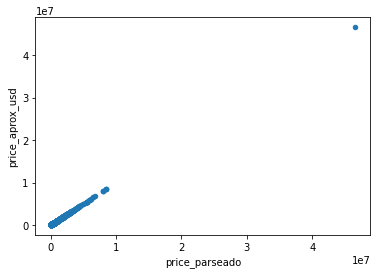

In [17]:
#Aca revisamos que la variable este correctamente expresada en dolares.
df_caba.plot.scatter(x = "price_parseado" ,y = "price_aprox_usd")

In [18]:
df_caba.head(2)

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,price_parseado
0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,...,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...,62000.0
2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,...,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...,72000.0


In [19]:
# Luego de hacer esta sustitución, vemos cuántos valores faltantes tenemos como % de cada columna en el dataframe de caba una vez hecha esta sustituciòn?
print("En el dataframe de caba, el porcentaje de valores nulos por columna ahora es:")
print(percent_missing_col(df_caba))

En el dataframe de caba, el porcentaje de valores nulos por columna ahora es:
floor                         90.688823
expenses                      79.601436
rooms                         52.577671
price_usd_per_m2              27.484837
lat-lon                       26.445105
lat                           26.445105
lon                           26.445105
surface_total_in_m2           18.192227
price_per_m2                  15.447456
price_aprox_local_currency    10.205471
currency                      10.205471
price                         10.205471
price_aprox_usd               10.205471
price_parseado                 9.363783
surface_covered_in_m2          7.237901
geonames_id                    3.979453
image_thumbnail                1.510088
properati_url                  0.000000
description                    0.000000
title                          0.000000
state_name                     0.000000
country_name                   0.000000
place_with_parent_names        0.000000
pl

Vemos que el % de nulos en la variable precio parseado es inferior al % de nulos de la variable precio original. 

In [20]:
#Caculamos la cantidad de valores nulos por columna
print(cant_nulos_por_col(df_caba))

operation                         0
property_type                     0
place_name                        0
place_with_parent_names           0
country_name                      0
state_name                        0
geonames_id                    1286
lat-lon                        8546
lat                            8546
lon                            8546
price                          3298
currency                       3298
price_aprox_local_currency     3298
price_aprox_usd                3298
surface_total_in_m2            5879
surface_covered_in_m2          2339
price_usd_per_m2               8882
price_per_m2                   4992
floor                         29307
rooms                         16991
expenses                      25724
properati_url                     0
description                       0
title                             0
image_thumbnail                 488
price_parseado                 3026
dtype: int64
None


Con los reemplazos que hicimos vemos que la cantidad de missing values de price es 3298 y la de price estimation es 3026, recuperamos 272 observaciones

In [21]:
# El siguiente paso es chequear que la columna nueva precio_parseado sea "razonable", comparándolo
#con la columna precio original.
print(df_caba.price_parseado.describe())
print("---------------------------")
print(df_caba.price.describe())

count    2.929000e+04
mean     2.689328e+05
std      4.558880e+05
min      1.150000e+03
25%      1.047082e+05
50%      1.570000e+05
75%      2.850000e+05
max      4.654544e+07
Name: price_parseado, dtype: float64
---------------------------
count    2.901800e+04
mean     3.829522e+05
std      1.081570e+06
min      5.500000e+03
25%      1.090000e+05
50%      1.658000e+05
75%      3.250000e+05
max      5.000000e+07
Name: price, dtype: float64


Cuando comparamos con los estadísticos de la variable original, no encontramos nada que llame la atención. De todas formas hacemos algunos chequeos adicionales.



In [22]:
#buscamos el valor máximo para validar que el precio sea correcto y coincida con la moneda

print(df_caba["price_aprox_usd"].idxmax())
print(df_caba.loc[24548,["price_aprox_usd","price","currency","surface_total_in_m2","floor","state_name","place_name","properati_url","lat-lon","price_usd_per_m2"]])

24548
price_aprox_usd                                              4.65454e+07
price                                                        4.65454e+07
currency                                                             USD
surface_total_in_m2                                               200000
floor                                                                NaN
state_name                                               Capital Federal
place_name                                                     San Telmo
properati_url          http://www.properati.com.ar/17ofp_venta_depart...
lat-lon                                          -34.6213421,-58.3741846
price_usd_per_m2                                                 232.727
Name: 24548, dtype: object


Habiendo logrado recuperar 272 observaciones, decidimos hacer un nuevo dataframe sin los valores nulos de la variable precio que no pudimos recuperar.

In [23]:
#Creamos un nuevo dataframe sin los valores de Y (price) que no pudimos recuperar
df_caba_sin_precio_nulos = df_caba[df_caba["price_parseado"].notnull()]

##### 3.3 Completar missing values de las variables explicativas




In [24]:
#Lo primero que hacemos es analizar los valores faltantes de este nuevo dataframe
print("En el dataframe de CABA sin precios faltantes, el valor de faltantes de las otras variables    asciende a:")
total_missing(df_caba_sin_precio_nulos)

En el dataframe de CABA sin precios faltantes, el valor de faltantes de las otras variables    asciende a:
102292


In [25]:
print("En el dataframe de CABA sin precios faltantes, el % de faltantes de las otras variables es de:")
percent_missing(df_caba_sin_precio_nulos)
print("")
print("Anteriormente el % de faltantes ascendia a")
percent_missing(df_caba)

En el dataframe de CABA sin precios faltantes, el % de faltantes de las otras variables es de:
13.432255692412742

Anteriormente el % de faltantes ascendia a
16.393879669037485


In [26]:
print("En el dataframe de CABA sin precios faltantes, el % de faltantes por columna es:")
percent_missing_col(df_caba_sin_precio_nulos)

En el dataframe de CABA sin precios faltantes, el % de faltantes por columna es:
floor                         89.904404
expenses                      78.330488
rooms                         49.508365
lat-lon                       23.584841
lat                           23.584841
lon                           23.584841
price_usd_per_m2              19.993172
surface_total_in_m2           19.050871
price_per_m2                   6.712188
surface_covered_in_m2          5.821099
geonames_id                    4.015022
image_thumbnail                1.433936
price_aprox_usd                0.928645
currency                       0.928645
price                          0.928645
price_aprox_local_currency     0.928645
country_name                   0.000000
place_with_parent_names        0.000000
place_name                     0.000000
property_type                  0.000000
price_parseado                 0.000000
state_name                     0.000000
properati_url                  0.000000

##### 3.3.1 Completar missing values de variables explicativas a partir parsear las columnas title y description


Una vez analizados los valores faltantes, empezamos a reconstruir lo que serán nuestras variables explicativas. 

In [27]:
#Empezamos por definir unas funciones que nos van a ayudar a parsear los datos

def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

def replace_nan_outlier(xserie):
    
    #iqr = threshold*(np.nanquantile(xserie,.75)-np.nanquantile(xserie,.25))
    #lower= iqr - np.nanquantile(xserie,.25)
    lower = np.nanquantile(xserie,.05)
    #high = iqr + np.nanquantile(xserie,.75)
    high = np.nanquantile(xserie,.95)
    new_val = [x if (x >= lower) & (x <= high) else np.nan for x in xserie]
    return new_val



Cuando exploramos la columna descripción y title vimos que en muchos casos contenian datos sobre cantidad de ambientes, pisos, expensas y superficie.
Nuestro objetivo es obtener toda la información que podamos de esas columnas para completar los valores faltantes de las variables:
    Supercie, floor, expensas y ambientes.
    

In [28]:
# Para eso empezamos creando diccionarios para reemplazar
dic_replace = {'monoambiente':'1dor','dormitorios':"dor","dormitorio":"dor","dorm":"dor","habitaciones":"dor","ambientes":"amb","metros cuadrados":"m2"}
dic_num = {"un":'1',"uno":'1',"dos":'2',"tres":'3',"cuatro":'4',"cinco":'5',"seis":'6',"siete":'7',"ocho":'8',"nueve":'9',"diez":'10'}
dic_ordinal = {"º":"piso","1er":"1", "2do":"2","3er":"3","4to":"4","5to":"5","6to":"6","7mo":"7","8vo":"8","9no":"9","10mo":"10",
              "1 er":"1", "2 do":"2","3 er":"3","4 to":"4","5 to":"5","6 to":"6","7 mo":"7","8vo ":"8","9 no":"9","10 mo":"10"}
dic_exp = {"expensas:":"expensas"}

In [29]:
#Luego casteamos las variables desde  la columna title.

#Área

area = [x.lower().replace("m²","m2").replace("metros cuadrados","m2").replace(" ","") for x in df_caba_sin_precio_nulos.title]
area_list = [find_num(x,r'(\d+)m2') for x in area ]
area_list = [ max(x) if len(x)>0 else np.nan for x in area_list]

#Ambientes

ambientes = [x.lower().replace("ambientes","amb").replace(" ","") for x in df_caba_sin_precio_nulos.title]
ambientes_list = [find_num(x,r'(\d+)amb') for x in ambientes ]
ambientes_list = [ min(x) if len(x)>0 else np.nan for x in ambientes_list]

#Dormitorios
dormitorios = [x.lower().replace("dormitorios","dor").replace(" ","") for x in df_caba_sin_precio_nulos.title]
dormitorios_list = [find_num(x,r'(\d+)dor') for x in dormitorios ]
dormitorios_list = [ max(x) if len(x)>0 else np.nan for x in dormitorios_list]

#Piso
title_piso = [replace_all(x.lower(), dic_ordinal) for x in df_caba_sin_precio_nulos.title]
piso_list1 = [find_num(x,r'(\d+) piso') for x in title_piso]
piso_list1 = [ min(x) if len(x)>0 else np.nan for x in piso_list1]
piso_list2 = [find_num(x,r'piso (\d+)') for x in title_piso]
piso_list2 = [ min(x) if len(x)>0 else np.nan for x in piso_list2]

max_floor_caba = 56 #no mas de 56 pisos segun wiki
piso2 = [x if x<=max_floor_caba else np.nan for x in piso_list2] 
piso1 = [x if x<=max_floor_caba else np.nan for x in piso_list1]

In [30]:
#El paso siguiente es unificar las variables

rooms_imputation_title = dormitorios_list
floor_imputation_title = unify_list(piso1,piso2)
area_imputation_title = area_list

C:\Users\Claudio\anaconda3\envs\dhdsblend2021_geopandas\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: All-NaN axis encountered
  # Remove the CWD from sys.path while we load stuff.


In [31]:
#Ahora vemos cuántos valores logramos salvar a partir de las transformaciones que hicimos.
cantidad_salvadas_rooms = len(rooms_imputation_title)-np.isnan(rooms_imputation_title).sum()
cantidad_salvadas_floor = len(floor_imputation_title)-np.isnan(floor_imputation_title).sum()
cantidad_salvadas_area = len(area_imputation_title)-np.isnan(area_imputation_title).sum()
print("La cantidad de observaciones salvadas de la variable room a partir de title es de:",cantidad_salvadas_rooms)
print("La cantidad de observaciones salvadas de la variable floor a partir de title es de:",cantidad_salvadas_floor )
print("La cantidad de observaciones salvadas de la variable área a partir de title es de:",cantidad_salvadas_area)

La cantidad de observaciones salvadas de la variable room a partir de title es de: 508
La cantidad de observaciones salvadas de la variable floor a partir de title es de: 461
La cantidad de observaciones salvadas de la variable área a partir de title es de: 1725


In [32]:
#Repetimos el mismo procedimiento para la columna description
descripcion = [replace_all(x.lower(), dic_replace) for x in df_caba_sin_precio_nulos.description]
descripcion = [replace_all(x, dic_num) for x in descripcion]
descripcion = [replace_all(x, dic_exp) for x in descripcion]
descripcion = [replace_all(x.replace(" ","").replace(".",""), dic_ordinal) for x in descripcion]

#Ambientes
ambientes_desc_list = [find_num(x,r'(\d+)amb') for x in descripcion]
ambientes_desc_list = [ min(x) if len(x)>0 else np.nan for x in ambientes_desc_list]

#Dormitorios
dormitorios_desc_list = [find_num(x,r'(\d+)dor') for x in descripcion ]
dormitorios_desc_list = [ max(x) if len(x)>0 else np.nan for x in dormitorios_desc_list]

#Area
area_desc_list = [find_num(x,r'(\d+)m2') for x in descripcion ]
area_desc_list = [ max(x) if len(x)>0 else np.nan for x in area_desc_list]

#Expensas
expensas_desc_list = [find_num(x,r'expensas\$(\d+)') for x in descripcion ]
expensas_desc_list = [ max(x) if len(x)>0 else np.nan for x in expensas_desc_list]

In [33]:
#Unificacion de variables
rooms_imputation_desc = dormitorios_desc_list
area_imputation_desc = area_desc_list
expensas_imputation_desc = expensas_desc_list

In [34]:
#Ahora vemos cuántos valores logramos salvar a partir de las transformaciones que hicimos.
cantidad_salvadas_rooms_d = len(rooms_imputation_desc)-np.isnan(rooms_imputation_desc).sum()
cantidad_salvadas_expensas_d = len(expensas_imputation_desc)-np.isnan(expensas_imputation_desc).sum()
cantidad_salvadas_area_d = len(area_imputation_desc)-np.isnan(area_imputation_desc).sum()
print("La cantidad de observaciones salvadas de la variable room a partir de title es de:",cantidad_salvadas_rooms_d)
print("La cantidad de observaciones salvadas de la variable expensas a partir de title es de:",cantidad_salvadas_expensas_d )
print("La cantidad de observaciones salvadas de la variable área a partir de title es de:",cantidad_salvadas_area_d)

La cantidad de observaciones salvadas de la variable room a partir de title es de: 8714
La cantidad de observaciones salvadas de la variable expensas a partir de title es de: 1913
La cantidad de observaciones salvadas de la variable área a partir de title es de: 7573


In [35]:
#Ahora unificamos los resultados encontrados en title y descripcion
rooms_desc_title = unify_list(rooms_imputation_desc,rooms_imputation_title)
area_desc_title =  unify_list(area_imputation_desc,area_imputation_title)
floor_desc_title = floor_imputation_title
expensas_desc_title = expensas_desc_list

C:\Users\Claudio\anaconda3\envs\dhdsblend2021_geopandas\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: All-NaN axis encountered
  # Remove the CWD from sys.path while we load stuff.


In [36]:
#El siguiente paso es crear una columna nueva para las variables que parseamos
df_caba_sin_precio_nulos.loc[:,"room_parseada"] = sustituir(df_caba_sin_precio_nulos.rooms,rooms_desc_title)
df_caba_sin_precio_nulos.loc[:,"area_parseada"] = sustituir(df_caba_sin_precio_nulos.surface_total_in_m2,area_desc_title)
df_caba_sin_precio_nulos.loc[:,"floor_parseada"] = sustituir(df_caba_sin_precio_nulos.floor,floor_desc_title)
df_caba_sin_precio_nulos.loc[:,"expensas_parseada"] = sustituir(df_caba_sin_precio_nulos.expenses,expensas_desc_title)
df_caba_sin_precio_nulos.loc[:,"ambientes_parseada"] = [ np.nanmin([x,y]) for x,y in zip(ambientes_desc_list,ambientes_list) ]

C:\Users\Claudio\anaconda3\envs\dhdsblend2021_geopandas\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Claudio\anaconda3\envs\dhdsblend2021_geopandas\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\Claudio\anaconda3\envs\dhdsblend2021_geopandas\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: All-NaN axis encountered
  


In [37]:
#Vemos cómo quedó nuestra base con los cambios
percent_missing_col(df_caba_sin_precio_nulos)

floor                         89.904404
floor_parseada                88.542165
expenses                      78.330488
expensas_parseada             73.451690
rooms                         49.508365
room_parseada                 36.230795
ambientes_parseada            34.895869
lat-lon                       23.584841
lat                           23.584841
lon                           23.584841
price_usd_per_m2              19.993172
surface_total_in_m2           19.050871
area_parseada                 13.806760
price_per_m2                   6.712188
surface_covered_in_m2          5.821099
geonames_id                    4.015022
image_thumbnail                1.433936
price_aprox_usd                0.928645
price_aprox_local_currency     0.928645
currency                       0.928645
price                          0.928645
properati_url                  0.000000
description                    0.000000
title                          0.000000
price_parseado                 0.000000


Vemos que el % de faltantes de área (metros cuadrados) sigue siendo alto 13.8% y todavía hay forma de seguir completando valores faltantes. En la próxima subsección nos concentraremos en esta variable.

##### 3.3.2 Completar missing values de la variable superficie 

Nuestro objetivo es estimar el precio de venta de las propiedades de CABA y para eso la variable metros cuadrados (surface_total_in_m2) es clave, pero nos falta el 13.8% de las observaciones. Entonces intentamos reconstruir la variable superficie:
A partir de 2 variables que tenemos: precio por metro cuadrado y precio total.

In [38]:
# Primero vamos a crear una columna para calcular la superficie a partir de variables que tenemos. Vamos a dividir el price_parseado por precio por metro cuadrado para obtener el valor de los metros cuadrados de aquellas
#propiedades que lo tienen como nulo.
df_caba_sin_precio_nulos["area_from_variables"] = df_caba_sin_precio_nulos["price_parseado"]/df_caba_sin_precio_nulos["price_per_m2"]

C:\Users\Claudio\anaconda3\envs\dhdsblend2021_geopandas\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
#Vemos ahora cuántos valores logramos encontrar, para eso comparamos el % de faltantes de area_parseada  con 
#el % de faltantes en la nueva columna m2_from_variables.
percent_missing_col(df_caba_sin_precio_nulos)

floor                         89.904404
floor_parseada                88.542165
expenses                      78.330488
expensas_parseada             73.451690
rooms                         49.508365
room_parseada                 36.230795
ambientes_parseada            34.895869
lat-lon                       23.584841
lat                           23.584841
lon                           23.584841
price_usd_per_m2              19.993172
surface_total_in_m2           19.050871
area_parseada                 13.806760
area_from_variables            6.712188
price_per_m2                   6.712188
surface_covered_in_m2          5.821099
geonames_id                    4.015022
image_thumbnail                1.433936
price_aprox_usd                0.928645
price_aprox_local_currency     0.928645
currency                       0.928645
price                          0.928645
properati_url                  0.000000
description                    0.000000
title                          0.000000


El porcentaje de faltantes de la variable superficie pasa de 13.8% a 6.7% (area_from_variables)

In [40]:
#Hacemos algunos chequeos para asegurarnos que la variable que creamos sea razonable.

#Primero vemos cómo lucen los reemplazos.
df_caba_sin_precio_nulos.loc[:,["area_from_variables","area_parseada"]].sample(50)

,area_from_variables,area_parseada
106189,165.000000,168.0
35904,37.000000,37.0
25466,25.000000,25.0
45793,132.000000,4.0
40686,92.000000,NaN
51246,NaN,300.0
71891,52.000000,55.0
16050,30.000000,40.0
38874,43.000000,46.0
119844,49.000000,53.0


In [41]:
#Ahora construimos una variable que sea la diferencia entre la variable que creamos y la variable area parseada
df_caba_sin_precio_nulos["area_diff"] = df_caba_sin_precio_nulos["area_from_variables"]-df_caba_sin_precio_nulos["area_parseada"]

C:\Users\Claudio\anaconda3\envs\dhdsblend2021_geopandas\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


La mediana de la diferencia es de -5.0 


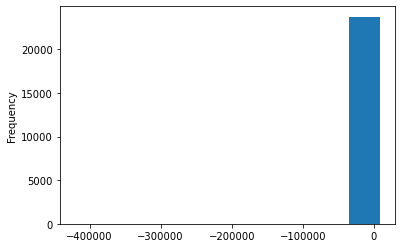

In [42]:
#Graficamos esa variable
df_caba_sin_precio_nulos["area_diff"].plot.hist(bins=10)
print(f"La mediana de la diferencia es de {df_caba_sin_precio_nulos.area_diff.median()} ")

Razonablemente la mayoría de las obervaciones se concentra en 0. Y por lo tanto creamos una nueva columna a partir de estos datos que logramos salvar

In [43]:
df_caba_sin_precio_nulos["area_completa"] = df_caba_sin_precio_nulos[["area_parseada","area_from_variables"]].apply(lambda x: x[1] if np.isnan(x[0]) else x[0], axis=1)

C:\Users\Claudio\anaconda3\envs\dhdsblend2021_geopandas\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
#Ahora vemos la cantidad de valores faltantes a partir de estos cambios
percent_missing_col(df_caba_sin_precio_nulos)

floor                         89.904404
floor_parseada                88.542165
expenses                      78.330488
expensas_parseada             73.451690
rooms                         49.508365
room_parseada                 36.230795
ambientes_parseada            34.895869
lat-lon                       23.584841
lat                           23.584841
lon                           23.584841
price_usd_per_m2              19.993172
surface_total_in_m2           19.050871
area_diff                     18.945032
area_parseada                 13.806760
area_from_variables            6.712188
price_per_m2                   6.712188
surface_covered_in_m2          5.821099
geonames_id                    4.015022
area_completa                  1.573916
image_thumbnail                1.433936
price_aprox_usd                0.928645
price_aprox_local_currency     0.928645
currency                       0.928645
price                          0.928645
properati_url                  0.000000


El porcentaje de valores faltantes de la variable m2 (area_completa) bajó a 1.57% gracias a los cambios.

##### 3.3.3 Completar missing values de la variable TBC...

<AxesSubplot:>

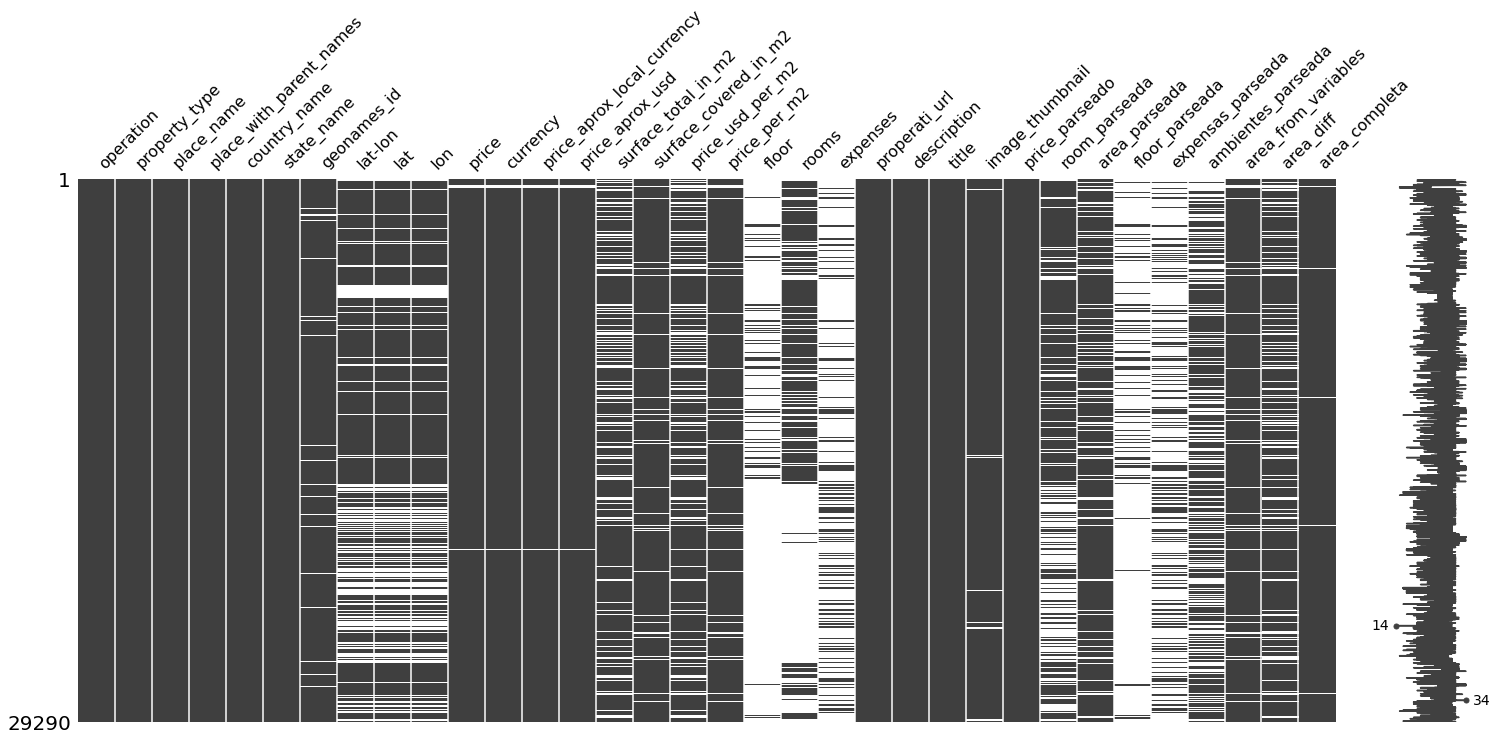

In [45]:
#Una herramienta grafica que nos permite explorar si existe una asociacion entre nulos es la siguente.
mno.matrix(df_caba_sin_precio_nulos)

In [46]:
variables = ["property_type","place_name","lat","lon","price_parseado","room_parseada","floor_parseada","area_completa","description"]

In [47]:
df_potencial = df_caba_sin_precio_nulos[variables]

In [48]:
df_potencial.shape

(29290, 9)

In [49]:
df_potencial.head(2)

,property_type,place_name,lat,lon,price_parseado,room_parseada,floor_parseada,area_completa,description
0,PH,Mataderos,-34.661824,-58.508839,62000.0,NaN,NaN,55.0,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,..."
2,apartment,Mataderos,-34.652262,-58.522982,72000.0,NaN,3.0,55.0,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...


In [50]:
percent_missing_col(df_potencial)

floor_parseada    88.542165
room_parseada     36.230795
lon               23.584841
lat               23.584841
area_completa      1.573916
description        0.000000
price_parseado     0.000000
place_name         0.000000
property_type      0.000000
dtype: float64


In [51]:
df_potencial_area_nula = df_potencial.loc[df_potencial["area_completa"].isnull()]

In [52]:
df_potencial_area_nula.place_name.value_counts()

Liniers                83
Mataderos              46
Villa Luro             43
Palermo                34
Recoleta               17
Capital Federal        17
Caballito              16
Flores                 15
Belgrano               14
Barrio Norte           13
Villa Lugano           12
Barracas               12
Villa Urquiza          10
Almagro                10
Floresta               10
Balvanera               9
San Cristobal           8
Nuñez                   7
San Telmo               7
Parque Patricios        6
Villa Devoto            5
San Nicolás             5
Chacarita               5
Paternal                4
Villa Crespo            4
Boedo                   4
Once                    4
Saavedra                4
Boca                    3
Coghlan                 3
Colegiales              3
Villa Pueyrredón        3
Pompeya                 3
Constitución            2
Abasto                  2
Palermo Soho            2
Palermo Hollywood       2
Parque Avellaneda       2
Congreso    

In [53]:
porcentaje_nulos_barrio = ((df_potencial_area_nula.place_name.value_counts()/df_potencial.place_name.value_counts())*100).sort_values(ascending = False)
porcentaje_nulos_barrio

Liniers            20.802005
Mataderos          11.386139
Villa Luro         10.411622
Villa Lugano        6.091371
Pompeya             5.084746
                     ...    
Versalles                NaN
Villa Ortuzar            NaN
Villa Real               NaN
Villa Riachuelo          NaN
Villa Soldati            NaN
Name: place_name, Length: 62, dtype: float64

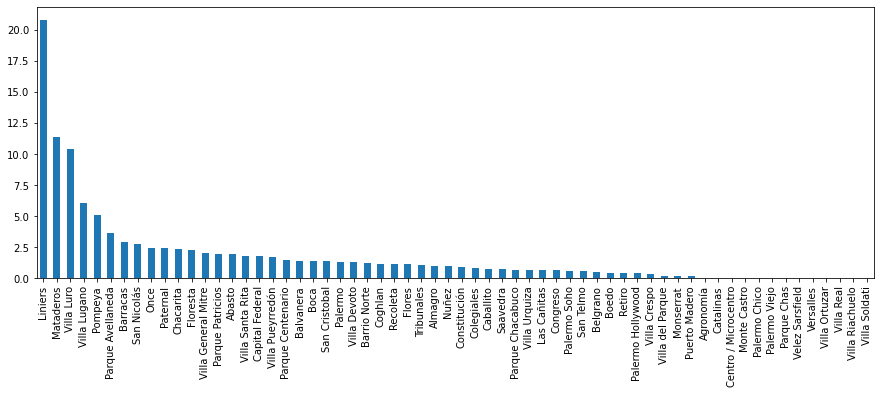

In [54]:
ax = porcentaje_nulos_barrio.plot.bar(figsize=(15, 5))

In [55]:
df_potencial = df_potencial.loc[~df_potencial.area_completa.isnull()].drop(columns = "floor_parseada")

In [56]:
#Variables extraidas de description.
df_potencial["description"] = [i.lower() for i in df_potencial.description]
df_potencial["nuevo"] = [int(i) for i in df_potencial.description.str.contains("estrenar")]
df_potencial["terraza"] = [int(i) for i in df_potencial.description.str.contains("terraza")]
df_potencial["alfrente"] = [int(i) for i in df_potencial.description.str.contains("al frente")]
df_potencial["reciclado"] = [int(i) for i in df_potencial.description.str.contains("reciclado")]

In [57]:
#Dummys property_type
df_potencial = pd.concat([df_potencial,pd.get_dummies(df_potencial.property_type,prefix = "prop_type")], axis=1)

In [58]:
percent_missing_col(df_potencial)

room_parseada          36.085192
lon                    23.705297
lat                    23.705297
prop_type_store         0.000000
prop_type_house         0.000000
prop_type_apartment     0.000000
prop_type_PH            0.000000
reciclado               0.000000
alfrente                0.000000
terraza                 0.000000
nuevo                   0.000000
description             0.000000
area_completa           0.000000
price_parseado          0.000000
place_name              0.000000
property_type           0.000000
dtype: float64


<AxesSubplot:>

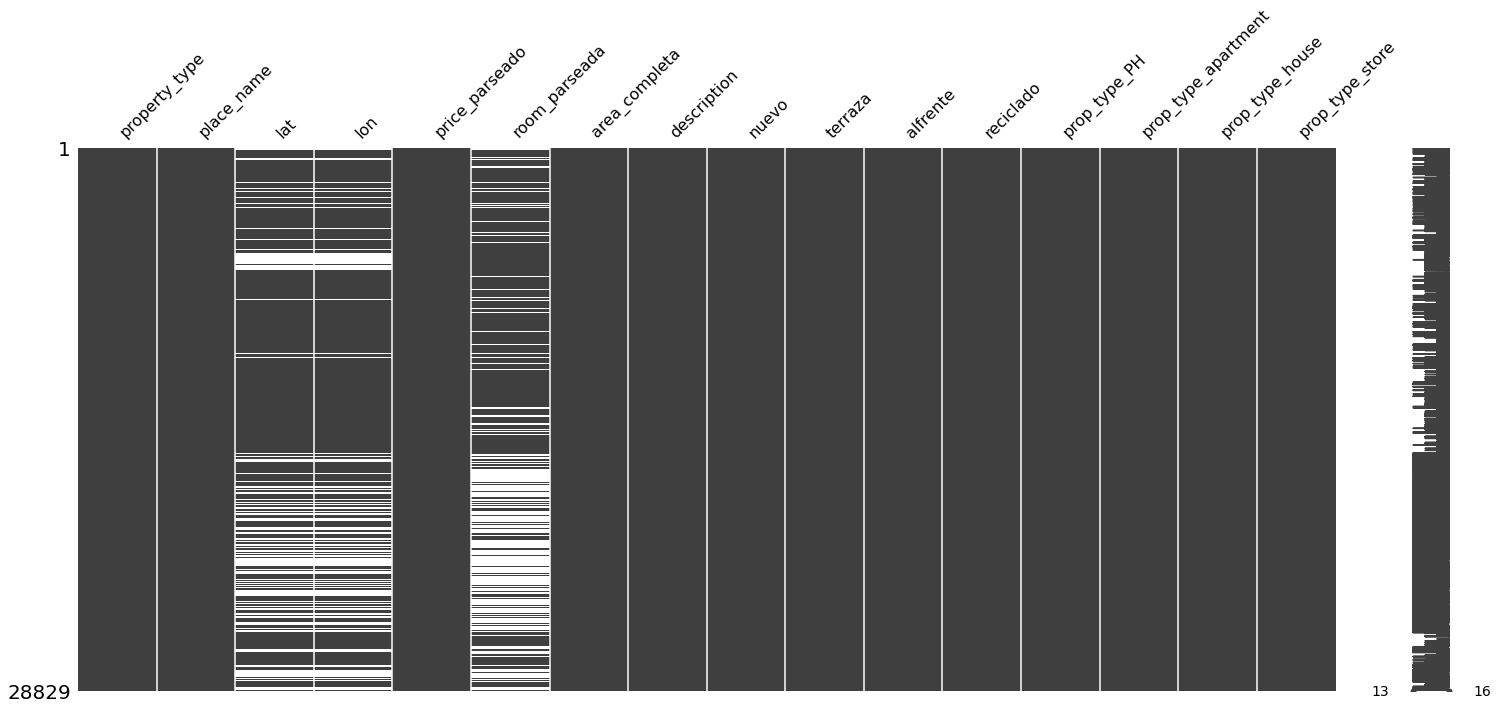

In [59]:
mno.matrix(df_potencial)

In [60]:
def Distance_checker(geo_df_base, geo_df_objetivo,nombre_columna = "columna_generada", radio_buffer = 500, crs = "epsg:5349"):
    
    #Se setean los dos geodataframes al mismo sistema de coodenadas de referencia y se muestra que esto se haya realizado con éxto 
    geo_df_base = geo_df_base.set_crs(crs, allow_override = True)
    geo_df_objetivo = geo_df_objetivo.set_crs(crs, allow_override = True)
    
    buffer = geo_df_objetivo.geometry.buffer(radio_buffer/100000) #para poder poner 500m pasé el número a la unidad en que creo, está el dataframe
    multipoligono = buffer.geometry.unary_union
    #multipoligono
    geo_df_base[nombre_columna] = geo_df_base["geometry"].apply(lambda x: 1 if multipoligono.contains(x) else 0) 
    #geo_df_base[nombre_columna + "_distance"] = geo_df_base["geometry"].apply(lambda x: 1 if multipoligono.distance(x) else 0) 
    
    return geo_df_base

In [61]:
#Geopandas.
filename = "bocas-de-subte.geojson"
file = open(filename, encoding ="utf8")
geo_subtes = gpd.read_file(file)

In [62]:
#Convierto el dataframe a GeoDataframe
geo_caba = gpd.GeoDataFrame(df_potencial, geometry = gpd.points_from_xy(df_potencial.lon, df_potencial.lat))
#Se setean los dos geodataframes al mismo sistema de coodenadas de referencia y se muestra que esto se haya realizado con éxto 
geo_caba = geo_caba.set_crs("epsg:5349", allow_override = True)
#En una primera iteración se encuentra un valor outlier con un dato de longitud que no tenía sentido. Se elimina.
mask_outlier = geo_caba.lon > -60
geo_caba = geo_caba[mask_outlier]

In [63]:
# Generacion de la variable subte_m500
geo_caba = Distance_checker(geo_caba, geo_subtes,nombre_columna = "subte_m500", radio_buffer = 500, crs = "epsg:5349")

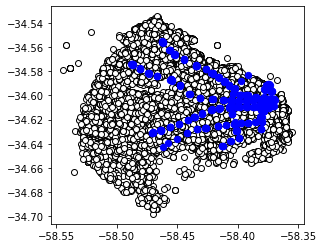

In [64]:
#se grafican las propiedades, las bocas de subte y estos buffers


fig, ax = plt.subplots()
ax.set_aspect('equal')
geo_caba.plot(ax=ax, color='white', edgecolor='black',aspect = 1.5)
geo_subtes.plot(ax=ax, marker='o', color='blue', markersize=40,aspect = 1)
plt.show();

In [65]:
#Espacios verdes.
#filename = "espacio-verde-publico.geojson"
#file = open(filename, encoding ="utf8")
#geo_verde = gpd.read_file(file)
#geo_verde = geo_verde.set_crs("epsg:5349", allow_override = True)

In [66]:
geo_caba.subte_m500.mean()

0.4778575975265982

In [67]:
geo_caba["description"] = [i.lower() for i in geo_caba.description]
geo_caba["nuevo"] = [int(i) for i in geo_caba.description.str.contains("estrenar")]
geo_caba["terraza"] = [int(i) for i in geo_caba.description.str.contains("terraza")]
geo_caba["alfrente"] = [int(i) for i in geo_caba.description.str.contains("al frente")]
geo_caba["reciclado"] = [int(i) for i in geo_caba.description.str.contains("reciclado")]

<AxesSubplot:>

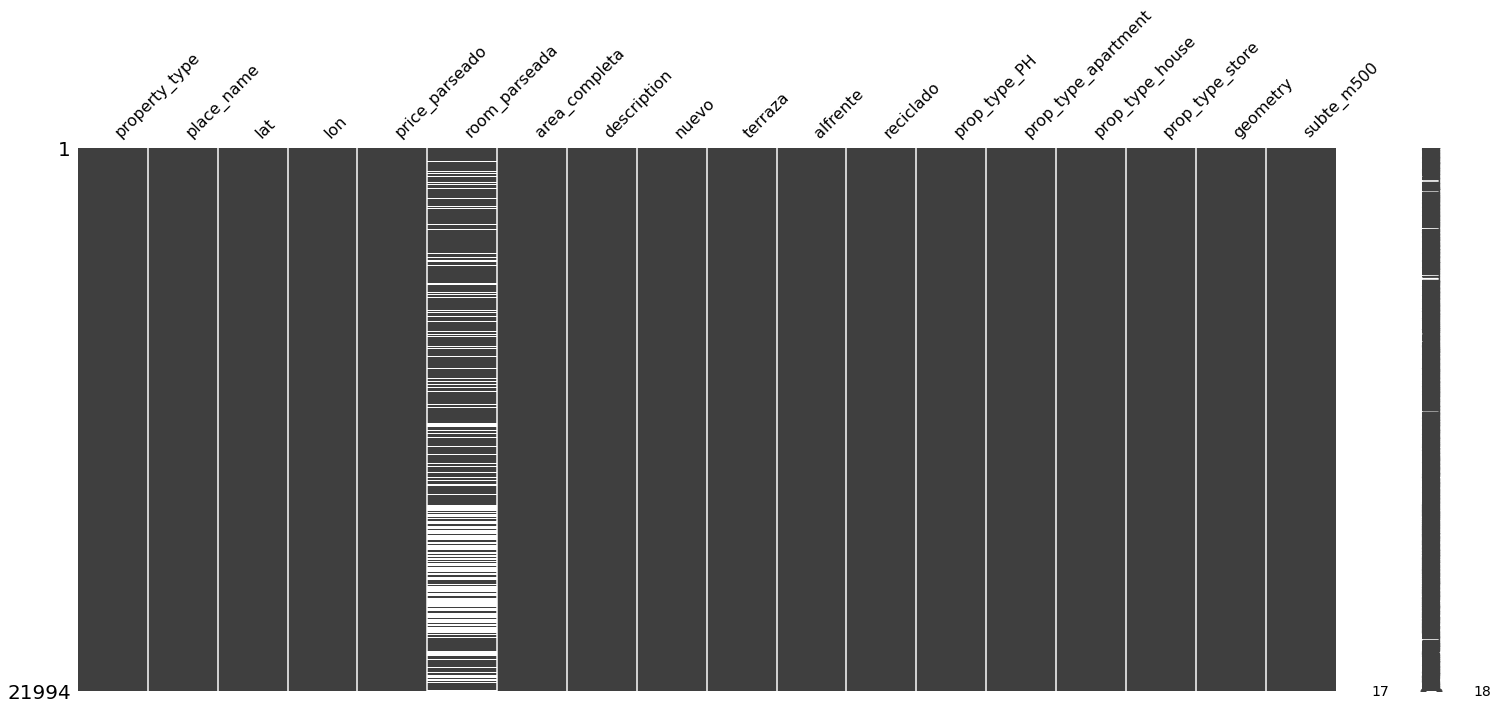

In [68]:
mno.matrix(geo_caba)

In [69]:
percent_missing(geo_caba)

1.6224121730168832


In [70]:
# Estimamos cuántos valores faltantes tenemos en total en la base de CABA.
print("En la base de CABA los valores faltantes ascienden a:")
total_missing(geo_caba)


En la base de CABA los valores faltantes ascienden a:
6423


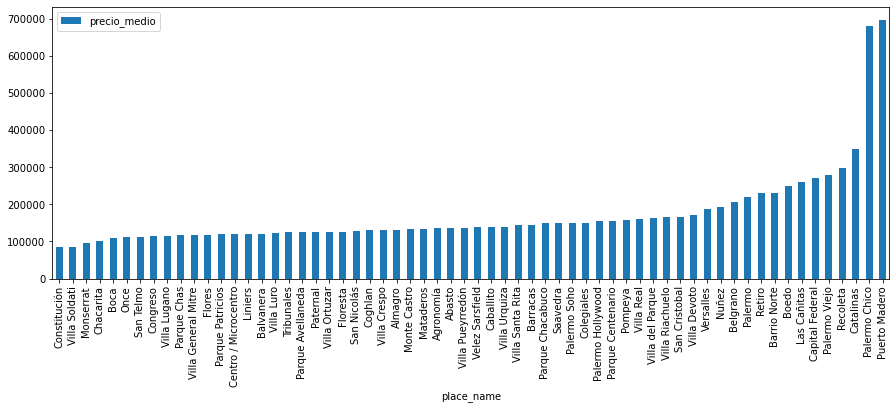

In [71]:
#Deberiamos estar tabajando con precios homologados
df_price_place=df_caba_sin_precio_nulos.groupby("place_name").agg(precio_medio = ('price_parseado','median')).sort_values(by = "precio_medio")
ax = df_price_place.plot.bar(figsize=(15, 5))

Para probar que tan bien es la imputacion necesitamos un dataset de comparacion.

## Se Carga y se trabaja sobre base de datos gastronomica

In [72]:
filename = "oferta-gastronomica.geojson"
file = open(filename, encoding ="utf8")
geo_gastro = gpd.read_file(file)


In [73]:
geo_gastro = geo_gastro.set_crs("epsg:5349", allow_override = True)
gastro_buffer_200m = geo_gastro.geometry.buffer(0.002) #paso un radio para este buffer de 200m

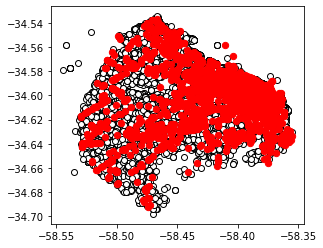

In [74]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
geo_caba.plot(ax=ax, color='white', edgecolor='black')
geo_gastro.plot(ax=ax, marker='o', color='red', markersize=40)
#gastro_buffer_200m.plot(ax=ax, marker='o', color='green', markersize=40, alpha = 0.2)
plt.show();

In [75]:
geo_gastro.head(4)

,long,lat,id,nombre,categoria,cocina,ambientacion,telefono,mail,horario,calle_nombre,calle_altura,calle_cruce,direccion_completa,barrio,comuna,codigo_postal,codigo_postal_argentino,geometry
0,-58.437169,-34.566017,1,MIL DOS,RESTAURANTE,TRADICIONAL,CLASICO PORTEÑO,4774 8411,None,None,SOLDADO DE LA INDEPENDENCIA,1002,None,SOLDADO DE LA INDEPENDENCIA 1002,Palermo,Comuna 14,1426.0,C1426BTN,POINT (-58.43717 -34.56602)
1,-58.425437,-34.585695,2,4 EN 2 I,RESTAURANTE,None,None,4832 9510,None,None,BORGES JORGE LUIS,2095,None,"BORGES, JORGE LUIS 2095",Palermo,Comuna 14,1425.0,C1425FFA,POINT (-58.42544 -34.58570)
2,-58.422262,-34.571843,3,4 X 4 CAFE,BAR,MINUTAS,None,4776 6000,info@4x4cafe.com,None,DEL LIBERTADOR,3838,None,DEL LIBERTADOR AV. 3838,Palermo,Comuna 14,1425.0,C1425ABY,POINT (-58.42226 -34.57184)
3,-58.439432,-34.583305,5,7 SEVEN,RESTAURANTE,PORTEÃ‘A,RUSTICA,4770 9698,None,None,GORRITI,5802,None,GORRITI 5802,Palermo,Comuna 14,1414.0,C1414BKJ,POINT (-58.43943 -34.58331)


In [76]:


def chequeo_individual_acu(buffer, row):
    
    """
    parametros:
    buffer
    row
    
    Esta función itera para cada fila del dataframe. Toma como entrada un buffer y una fila (se aplica en un apply o en un map)
    y devuelve una cantidad de elementos que cumplen con la condición dada.
    """
    lista =[]
    lista2=[]
    
    #para cada fila del buffer de bocas de subte
    for i in range(len(buffer)):
        #si el buffer[i] contiene a la propiedad de interes se cumple la condicion y se calcula la distancia
        if (buffer[i].contains(row)):
            
            auxiliar = geopy.distance.geodesic((buffer[i].centroid.x,buffer[i].centroid.y),
                  (row.x
                  ,row.y)).meters
            lista.append(True)
            lista2.append(i)
           

            
    # return list(zip(lista2,lista)) se puede retornar como resultado una lista de dos elementos con el indice de la estacion de subtes y el valor de distancia
    return sum(lista) #en este caso solo se selecciona el valor de menor distancia para cada punto
        

In [77]:
#aplico la función que definí y chequeo los valores obtenidos.

t0 = time.process_time()
geo_caba["gastro_m200"] = geo_caba["geometry"].apply(lambda x: chequeo_individual_acu(gastro_buffer_200m, x)) 
t1 = time.process_time() - t0
print ("The elapsed time was:", t1)
geo_caba["gastro_m200"].value_counts()

The elapsed time was: 576.46875


0     6232
1     3131
2     2292
3     1700
5     1490
4     1187
6      952
7      694
8      517
9      484
10     423
11     408
12     338
13     243
14     207
15     194
18     168
16     163
19     163
17     160
25     112
22      76
20      74
27      62
23      56
21      54
24      48
28      44
26      40
29      33
48      33
30      27
31      22
32      20
50      12
56      12
44      11
45      11
39      10
33       8
49       8
42       8
34       8
46       7
43       7
35       6
51       6
40       6
38       5
52       4
59       3
36       3
37       3
41       3
47       3
53       1
57       1
55       1
Name: gastro_m200, dtype: int64

<AxesSubplot:>

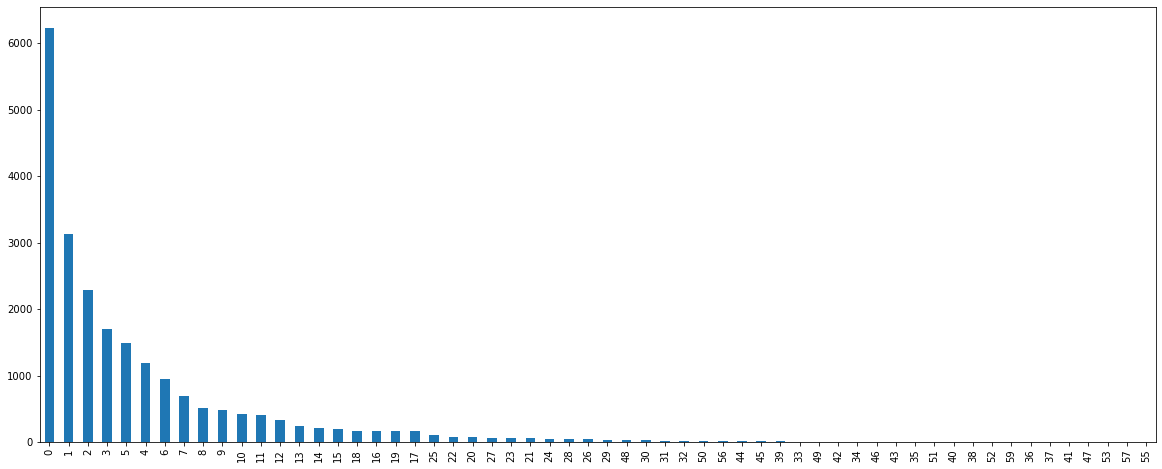

In [78]:
#Acá se grafican la cantidad de locales cercanos en el eje X y la cantidad de propiedades con esos locales cercanos en el eje Y

geo_caba["gastro_m200"].value_counts().plot(kind = "bar", figsize = (20,8))

## Se cargan datos de estadios y se trabaja sobre eso

In [79]:

df_estadios = pd.read_csv("estadios.csv")
df_estadios.head(2)

,long,lat,id,club,estadio,web,facebook,twitter,contacto,objeto,calle,altura,barrio,comuna,codigo_postal,codigo_postal_argentino
0,-58.449766,-34.545306,1,Club Atletico River Plate,Monumental Antonio Vespucio Liberti,http://www.cariverplate.com.ar/,https://www.facebook.com/riverplateoficial,https://twitter.com/@CARPoficial,54 11) 4789 1200,Estadio,Av. Figueroa Alcorta,7597.0,Belgrano,Comuna 13,1428.0,C1428BCL
1,-58.520663,-34.635330,2,Club Atlético Vélez Sarsfield,José Amalfitani,http://www.velezsarsfield.com.ar/,https://www.facebook.com/velezsarsfield,https://twitter.com/Velez,(54-11) 4641-5653/5763/4014,Estadio,Av. Juan B. Justo,9200.0,Liniers,Comuna 9,1408.0,C1408AKU


In [80]:
geo_estadios = gpd.GeoDataFrame(df_estadios, geometry = gpd.points_from_xy(df_estadios.long, df_estadios.lat))
geo_estadios = geo_estadios.set_crs("epsg:5349", allow_override = True)

In [81]:

estadio_buffer_200m = geo_estadios.geometry.buffer(0.002) #paso un radio para este buffer de 200m

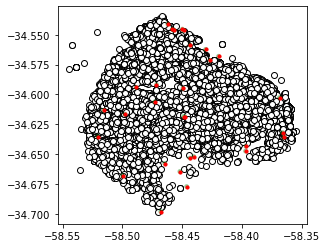

In [82]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
geo_caba.plot(ax=ax, color='white', edgecolor='black')
estadio_buffer_200m.plot(ax=ax, marker='o', color='green', markersize=60, alpha = 0.4)
geo_estadios.plot(ax=ax, marker='o', color='red', markersize=10)

plt.show();

In [83]:


t0 = time.process_time()
geo_caba["estadio_m200"] = geo_caba["geometry"].apply(lambda x: chequeo_individual_acu(estadio_buffer_200m, x)) 
t1 = time.process_time() - t0
print("Elapsed time is:",round(t1,2),"s")

Elapsed time is: 5.56 s


In [84]:
geo_caba["estadio_m200"].value_counts()

0    21823
1      161
2       10
Name: estadio_m200, dtype: int64

<AxesSubplot:>

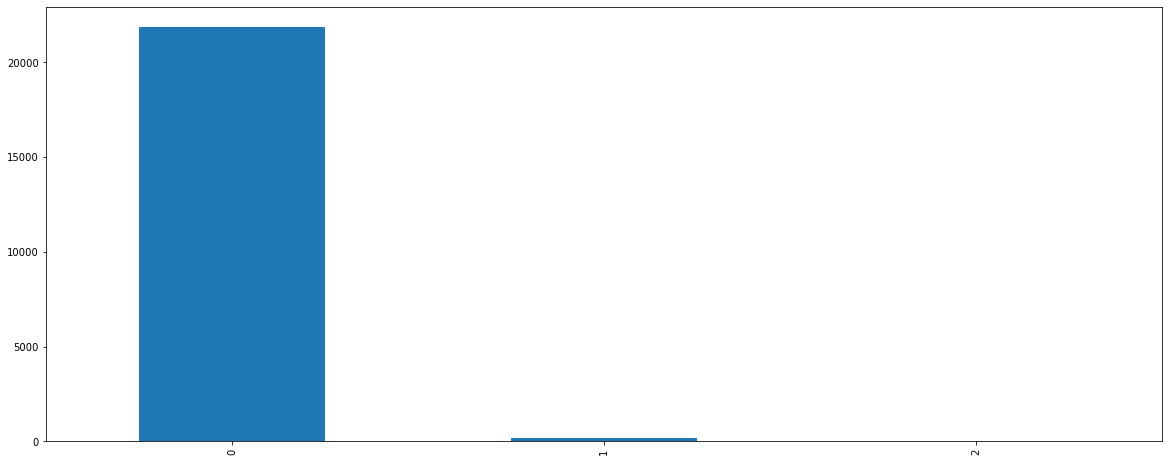

In [85]:
geo_caba["estadio_m200"].value_counts().plot(kind = "bar", figsize = (20,8))

In [86]:
geo_caba_dummies = pd.get_dummies(geo_caba, columns = ['place_name'])

In [87]:
geo_caba_dummies["subte_m500"]

0         0
2         0
7         0
8         0
16        0
         ..
121153    1
121158    1
121160    0
121209    0
121217    0
Name: subte_m500, Length: 21994, dtype: int64

In [88]:

geo_caba_dummies.to_parquet('geo_caba_mod.parquet')

C:\Users\Claudio\anaconda3\envs\dhdsblend2021_geopandas\lib\site-packages\ipykernel_launcher.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  """Entry point for launching an IPython kernel.


In [89]:
geo_caba.dtypes

property_type            object
place_name               object
lat                     float64
lon                     float64
price_parseado          float64
room_parseada           float64
area_completa           float64
description              object
nuevo                     int64
terraza                   int64
alfrente                  int64
reciclado                 int64
prop_type_PH              uint8
prop_type_apartment       uint8
prop_type_house           uint8
prop_type_store           uint8
geometry               geometry
subte_m500                int64
gastro_m200               int64
estadio_m200              int64
dtype: object

In [90]:
df_corr = geo_caba[["price_parseado","room_parseada","area_completa",
                      "subte_m500","gastro_m200","estadio_m200","place_name","property_type","nuevo","alfrente","terraza"]]



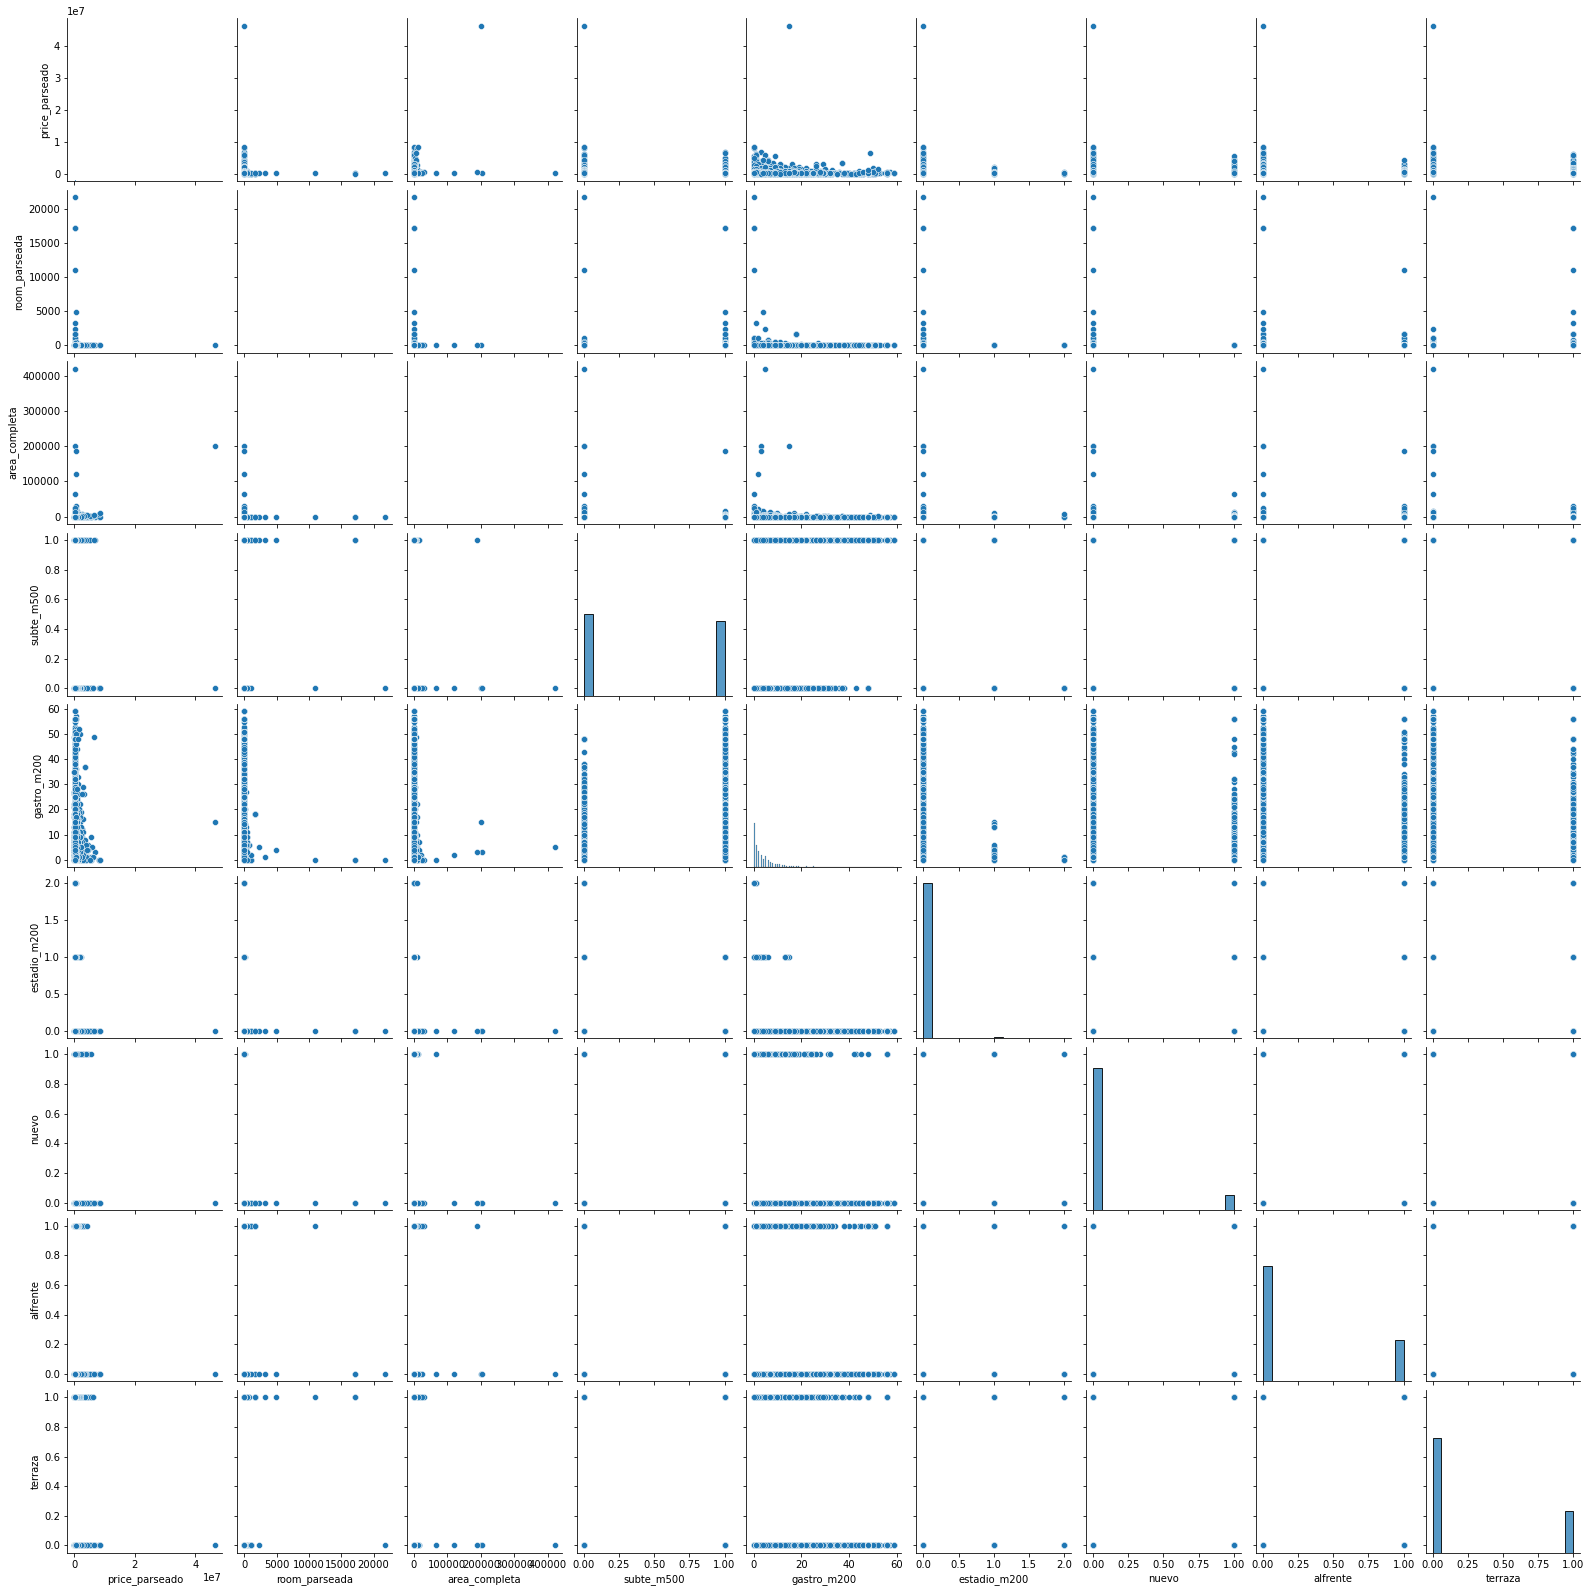

In [91]:

sns.pairplot(df_corr)


In [92]:
def replace_nan_outlier(xserie):
    
    #iqr = threshold*(np.nanquantile(xserie,.75)-np.nanquantile(xserie,.25))
    #lower= iqr - np.nanquantile(xserie,.25)
    lower = np.nanquantile(xserie,.05)
    #high = iqr + np.nanquantile(xserie,.75)
    high = np.nanquantile(xserie,.95)
    new_val = [x if (x >= lower) & (x <= high) else np.nan for x in xserie]
    return new_val

In [93]:
df_corr["area_sin_outlier"]=replace_nan_outlier(df_corr["area_completa"])

C:\Users\Claudio\anaconda3\envs\dhdsblend2021_geopandas\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

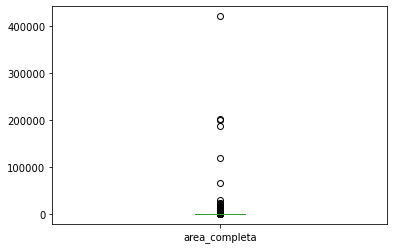

In [94]:
df_corr["area_completa"].plot(kind ="box")

<AxesSubplot:>

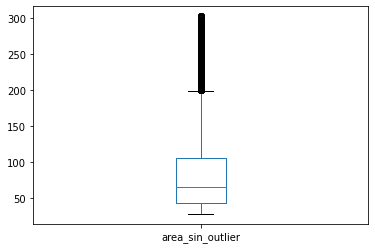

In [95]:
df_corr["area_sin_outlier"].plot(kind ="box")

<AxesSubplot:>

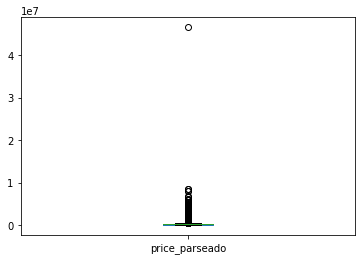

In [96]:
df_corr["price_parseado"].plot(kind = "box")

In [97]:
df_corr["price_sin_outlier"]=replace_nan_outlier(df_corr["price_parseado"])

C:\Users\Claudio\anaconda3\envs\dhdsblend2021_geopandas\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

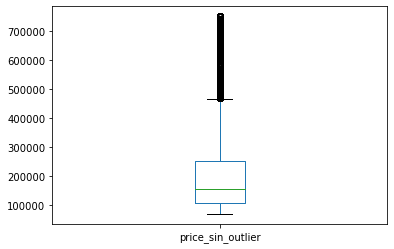

In [98]:
df_corr["price_sin_outlier"].plot(kind = "box")

<AxesSubplot:>

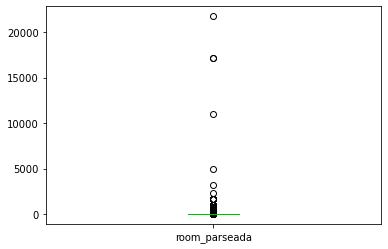

In [99]:
df_corr["room_parseada"].plot(kind = "box")

In [100]:
df_corr["room_sin_outlier"]=replace_nan_outlier(df_corr["room_parseada"])

C:\Users\Claudio\anaconda3\envs\dhdsblend2021_geopandas\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

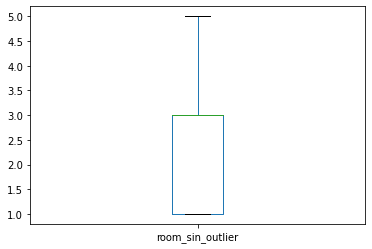

In [101]:
df_corr["room_sin_outlier"].plot(kind = "box")

In [102]:
df_corr_clean = df_corr[["price_sin_outlier","room_sin_outlier","area_sin_outlier",
                      "subte_m500","place_name","property_type","nuevo","alfrente","terraza","gastro_m200"]]

In [103]:
df_corr_clean.corr(method='pearson', min_periods=1)

,price_sin_outlier,room_sin_outlier,area_sin_outlier,subte_m500,nuevo,alfrente,terraza,gastro_m200
price_sin_outlier,1.000000,0.513982,0.680230,-0.053264,-0.110057,0.017574,0.110998,0.064655
room_sin_outlier,0.513982,1.000000,0.681216,-0.046592,-0.202478,0.070998,0.075598,-0.025368
area_sin_outlier,0.680230,0.681216,1.000000,-0.074685,-0.136374,0.044283,0.178834,-0.001338
subte_m500,-0.053264,-0.046592,-0.074685,1.000000,-0.068770,0.009135,-0.132907,0.281326
nuevo,-0.110057,-0.202478,-0.136374,-0.068770,1.000000,0.019597,0.057424,-0.066150
alfrente,0.017574,0.070998,0.044283,0.009135,0.019597,1.000000,0.070596,-0.030606
terraza,0.110998,0.075598,0.178834,-0.132907,0.057424,0.070596,1.000000,-0.114235
gastro_m200,0.064655,-0.025368,-0.001338,0.281326,-0.066150,-0.030606,-0.114235,1.000000


In [104]:
df_corr_clean[df_corr_clean["place_name"]=="Palermo"].corr(method='pearson', min_periods=1)

,price_sin_outlier,room_sin_outlier,area_sin_outlier,subte_m500,nuevo,alfrente,terraza,gastro_m200
price_sin_outlier,1.000000,0.607851,0.790327,0.025309,-0.071964,0.055660,0.103866,0.074784
room_sin_outlier,0.607851,1.000000,0.660342,0.051470,-0.196442,0.107862,-0.004539,-0.004748
area_sin_outlier,0.790327,0.660342,1.000000,-0.014581,-0.143612,0.082914,0.131561,-0.013448
subte_m500,0.025309,0.051470,-0.014581,1.000000,-0.067235,-0.023699,-0.107874,0.166876
nuevo,-0.071964,-0.196442,-0.143612,-0.067235,1.000000,0.068094,0.083296,-0.055079
alfrente,0.055660,0.107862,0.082914,-0.023699,0.068094,1.000000,0.057643,-0.029175
terraza,0.103866,-0.004539,0.131561,-0.107874,0.083296,0.057643,1.000000,0.008201
gastro_m200,0.074784,-0.004748,-0.013448,0.166876,-0.055079,-0.029175,0.008201,1.000000


In [105]:
df_corr_clean[df_corr_clean["place_name"]=="Mataderos"].corr(method='pearson', min_periods=1)

,price_sin_outlier,room_sin_outlier,area_sin_outlier,subte_m500,nuevo,alfrente,terraza,gastro_m200
price_sin_outlier,1.000000,0.267917,0.695396,NaN,-0.176556,0.048352,0.166549,-0.083522
room_sin_outlier,0.267917,1.000000,0.513882,NaN,-0.286741,0.194946,0.252619,-0.004957
area_sin_outlier,0.695396,0.513882,1.000000,NaN,-0.213076,0.027553,0.162068,-0.056510
subte_m500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nuevo,-0.176556,-0.286741,-0.213076,NaN,1.000000,-0.123464,-0.013471,0.030901
alfrente,0.048352,0.194946,0.027553,NaN,-0.123464,1.000000,0.117612,0.107398
terraza,0.166549,0.252619,0.162068,NaN,-0.013471,0.117612,1.000000,0.106513
gastro_m200,-0.083522,-0.004957,-0.056510,NaN,0.030901,0.107398,0.106513,1.000000


In [106]:
df_corr_clean.shape

(21994, 10)

In [107]:
df_corr_clean_no_nan = df_corr_clean.dropna(subset=["price_sin_outlier"])

In [108]:
df_corr_clean_no_nan.shape


(19828, 10)

In [109]:
df_grafico_presentacion = df_corr_clean[["price_sin_outlier","room_sin_outlier","area_sin_outlier","place_name","property_type","subte_m500","gastro_m200","nuevo","alfrente","terraza"]]

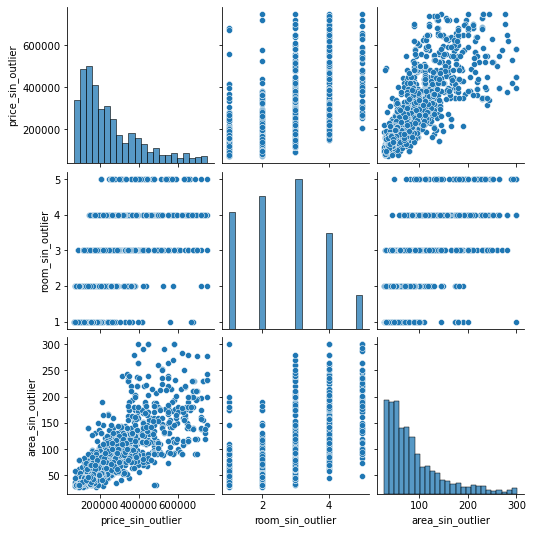

In [110]:

sns.pairplot(df_grafico_presentacion.loc[df_grafico_presentacion["place_name"]=="Palermo"], vars = ["price_sin_outlier","room_sin_outlier","area_sin_outlier"] )


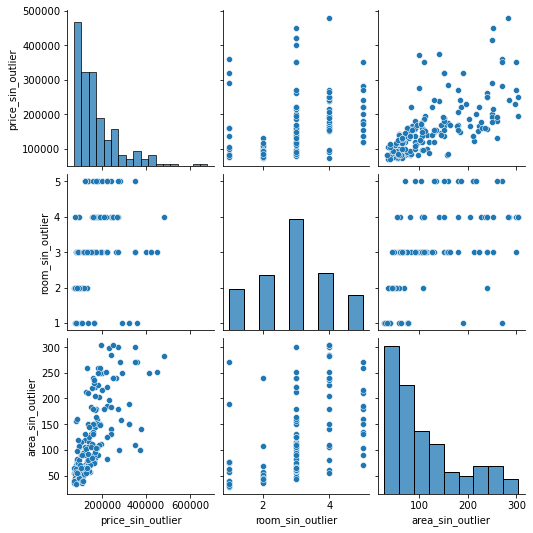

In [111]:
sns.pairplot(df_grafico_presentacion.loc[df_grafico_presentacion["place_name"]=="Mataderos"], vars = ["price_sin_outlier","room_sin_outlier","area_sin_outlier"])

C:\Users\Claudio\anaconda3\envs\dhdsblend2021_geopandas\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Claudio\anaconda3\envs\dhdsblend2021_geopandas\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Claudio\anaconda3\envs\dhdsblend2021_geopandas\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


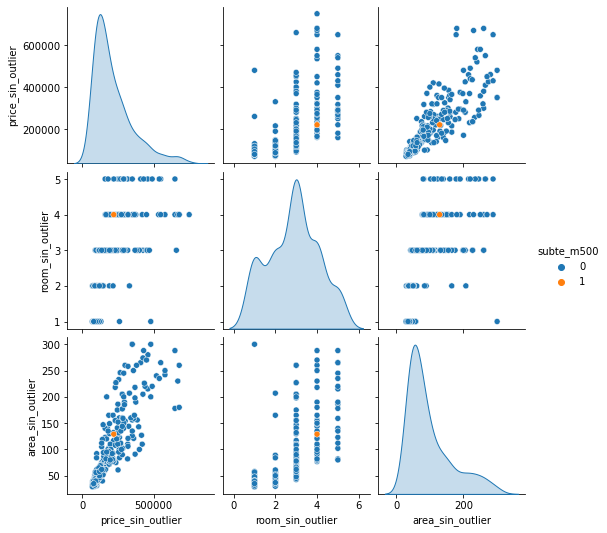

In [112]:
sns.pairplot(df_grafico_presentacion.loc[df_grafico_presentacion["place_name"]=="Villa Devoto"], vars = ["price_sin_outlier","room_sin_outlier","area_sin_outlier"], hue = "subte_m500")

C:\Users\Claudio\anaconda3\envs\dhdsblend2021_geopandas\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Claudio\anaconda3\envs\dhdsblend2021_geopandas\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Claudio\anaconda3\envs\dhdsblend2021_geopandas\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


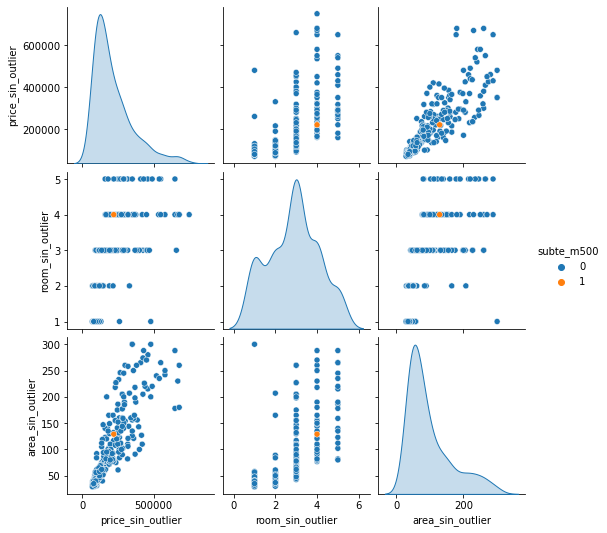

In [113]:
sns.pairplot(df_grafico_presentacion.loc[df_grafico_presentacion["place_name"]=="Villa Devoto"], vars = ["price_sin_outlier","room_sin_outlier","area_sin_outlier"], hue = "subte_m500")

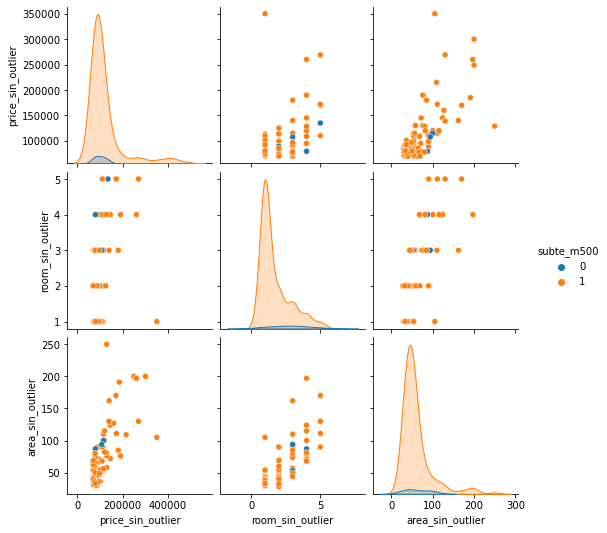

In [114]:
sns.pairplot(df_grafico_presentacion.loc[df_grafico_presentacion["place_name"]=="Constitución"], vars = ["price_sin_outlier","room_sin_outlier","area_sin_outlier"], hue = "subte_m500")

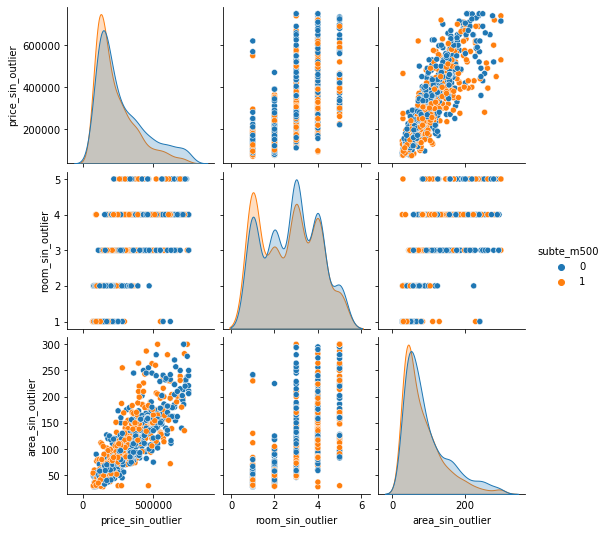

In [115]:
sns.pairplot(df_grafico_presentacion.loc[df_grafico_presentacion["place_name"]=="Belgrano"], vars = ["price_sin_outlier","room_sin_outlier","area_sin_outlier"], hue = "subte_m500")

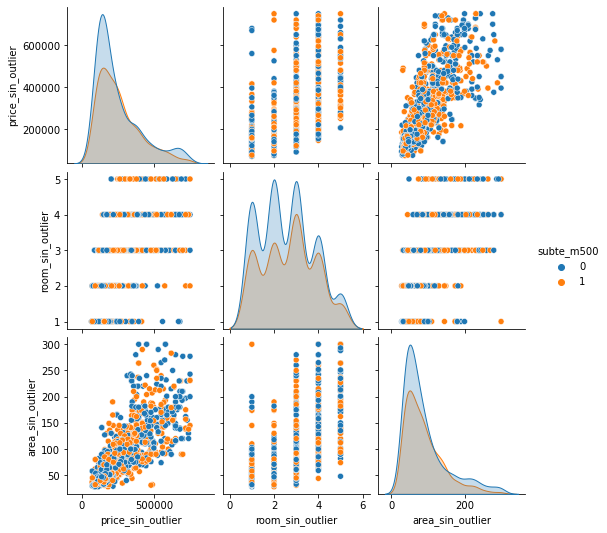

In [116]:
sns.pairplot(df_grafico_presentacion.loc[df_grafico_presentacion["place_name"]=="Palermo"], vars = ["price_sin_outlier","room_sin_outlier","area_sin_outlier"], hue = "subte_m500")

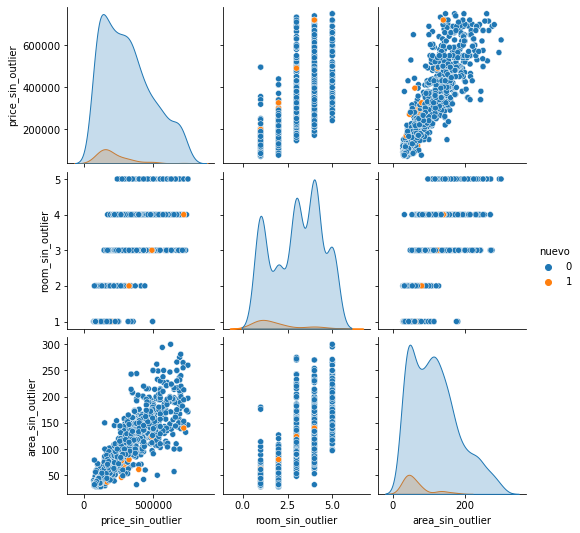

In [117]:
sns.pairplot(df_grafico_presentacion.loc[df_grafico_presentacion["place_name"]=="Recoleta"], vars = ["price_sin_outlier","room_sin_outlier","area_sin_outlier"], hue = "nuevo")

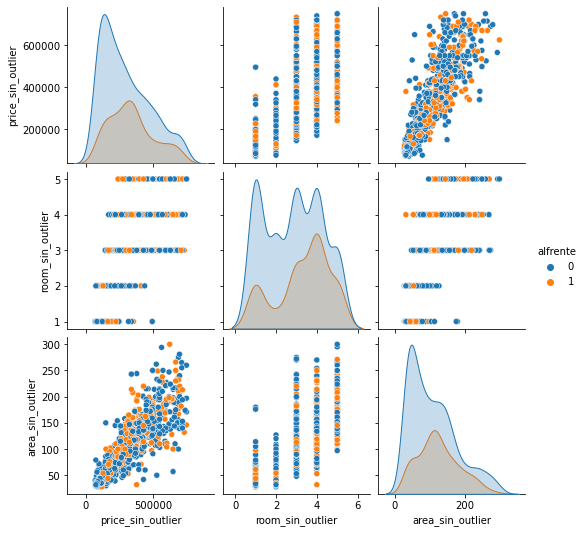

In [118]:
sns.pairplot(df_grafico_presentacion.loc[df_grafico_presentacion["place_name"]=="Recoleta"], vars = ["price_sin_outlier","room_sin_outlier","area_sin_outlier"], hue = "alfrente")

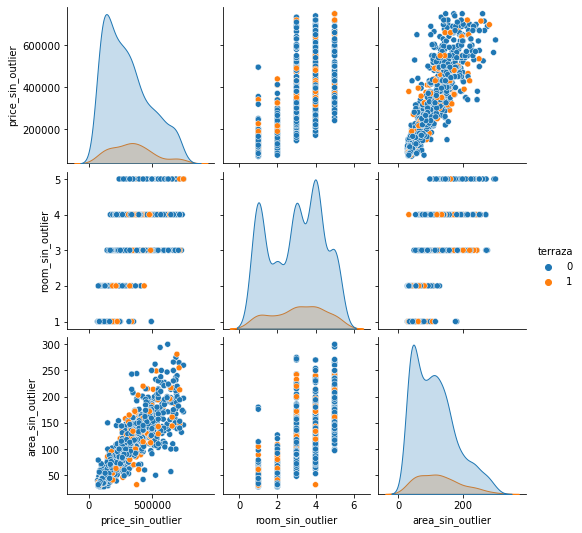

In [119]:
sns.pairplot(df_grafico_presentacion.loc[df_grafico_presentacion["place_name"]=="Recoleta"], vars = ["price_sin_outlier","room_sin_outlier","area_sin_outlier"], hue = "terraza")

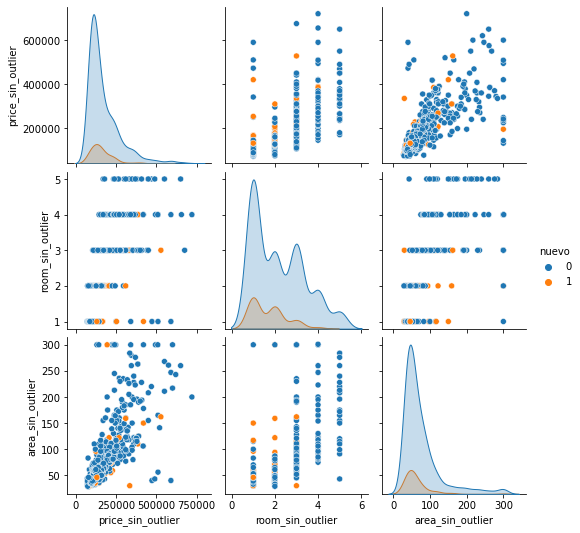

In [120]:
sns.pairplot(df_grafico_presentacion.loc[df_grafico_presentacion["place_name"]=="Villa Urquiza"], vars = ["price_sin_outlier","room_sin_outlier","area_sin_outlier"], hue = "nuevo")

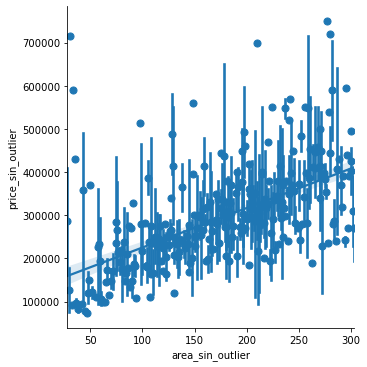

In [121]:
sns.lmplot(x="area_sin_outlier", y="price_sin_outlier", data=df_corr_clean_no_nan.loc[df_corr_clean_no_nan["property_type"]=="house"], x_estimator=np.mean );

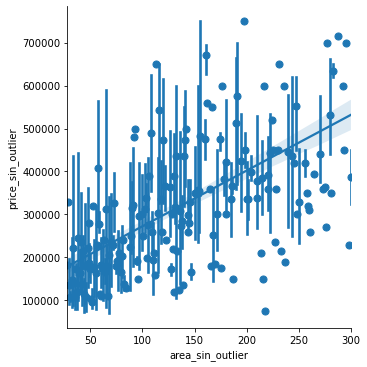

In [122]:
sns.lmplot(x="area_sin_outlier", y="price_sin_outlier", data=df_corr_clean_no_nan.loc[df_corr_clean_no_nan["property_type"]=="store"], x_estimator=np.mean );

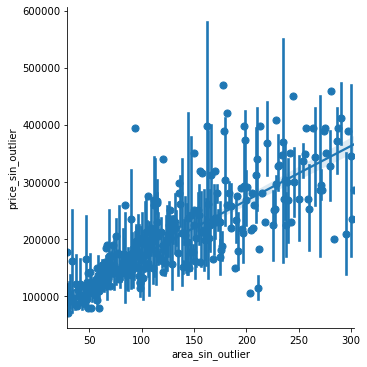

In [123]:
sns.lmplot(x="area_sin_outlier", y="price_sin_outlier", data=df_corr_clean_no_nan.loc[df_corr_clean_no_nan["property_type"]=="PH"], x_estimator=np.mean );

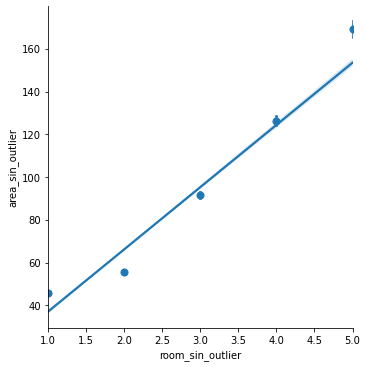

In [124]:
sns.lmplot(x="room_sin_outlier", y="area_sin_outlier", data=df_corr_clean_no_nan, x_estimator=np.mean);

<AxesSubplot:xlabel='property_type'>

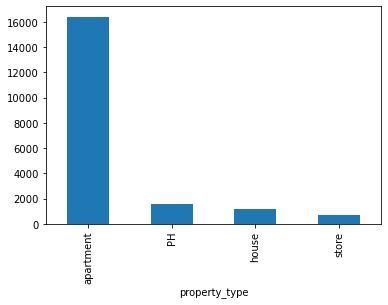

In [125]:
df_corr_clean_no_nan.groupby(["property_type"])["price_sin_outlier"].count().sort_values(ascending = False).plot(kind="bar")

<AxesSubplot:xlabel='place_name'>

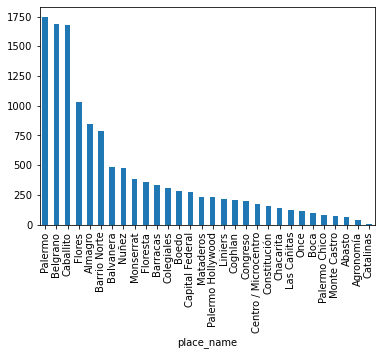

In [126]:
df_corr_clean_no_nan.groupby(["place_name"])["price_sin_outlier"].count().head(30).sort_values(ascending = False).plot(kind="bar")

## Se importa un geo_dataframe con los barrios de caba para imputar capital federal

In [127]:
#Importo los barrios de CABA
filename = "barrios.geojson"
file = open(filename, encoding ="utf8")
geo_barrios = gpd.read_file(file)

In [128]:


geo_barrios.head(5)

,barrio,comuna,perimetro,area,geometry
0,CHACARITA,15,7724.852955,3.115707e+06,"POLYGON ((-58.45282 -34.59599, -58.45366 -34.5..."
1,PATERNAL,15,7087.513295,2.229829e+06,"POLYGON ((-58.46558 -34.59656, -58.46562 -34.5..."
2,VILLA CRESPO,15,8131.857075,3.615978e+06,"POLYGON ((-58.42375 -34.59783, -58.42495 -34.5..."
3,VILLA DEL PARQUE,11,7705.389797,3.399596e+06,"POLYGON ((-58.49461 -34.61487, -58.49479 -34.6..."
4,ALMAGRO,5,8537.901368,4.050752e+06,"POLYGON ((-58.41287 -34.61412, -58.41282 -34.6..."


In [129]:
#Creo un nuevo dataframe
geo_barrios_case = geo_barrios

In [130]:
#Convierto el texto
geo_barrios_case["barrio"]=geo_barrios_case["barrio"].apply(lambda x: x.title())
geo_barrios_case.head(4)

,barrio,comuna,perimetro,area,geometry
0,Chacarita,15,7724.852955,3.115707e+06,"POLYGON ((-58.45282 -34.59599, -58.45366 -34.5..."
1,Paternal,15,7087.513295,2.229829e+06,"POLYGON ((-58.46558 -34.59656, -58.46562 -34.5..."
2,Villa Crespo,15,8131.857075,3.615978e+06,"POLYGON ((-58.42375 -34.59783, -58.42495 -34.5..."
3,Villa Del Parque,11,7705.389797,3.399596e+06,"POLYGON ((-58.49461 -34.61487, -58.49479 -34.6..."


In [131]:
serie_capital_federal = geo_caba[geo_caba["place_name"]=="Capital Federal"]

In [132]:
serie_capital_federal.head(4)

,property_type,place_name,lat,lon,price_parseado,room_parseada,area_completa,description,nuevo,terraza,alfrente,reciclado,prop_type_PH,prop_type_apartment,prop_type_house,prop_type_store,geometry,subte_m500,gastro_m200,estadio_m200
901,apartment,Capital Federal,-34.610862,-58.411706,120000.0,3.0,62.0,dueño vende hermoso 3 amb + entrepiso. excelen...,0,0,1,0,0,1,0,0,POINT (-58.41171 -34.61086),1,8,0
1081,apartment,Capital Federal,-34.547904,-58.465996,82000.0,1.0,56.0,"tigre: departamento 2amb. en planta baja (sum,...",0,0,0,0,0,1,0,0,POINT (-58.46600 -34.54790),0,1,0
2844,apartment,Capital Federal,-34.602769,-58.368315,55000.0,NaN,30.0,1 ambiente con patio servicios individualesinf...,0,0,0,0,0,1,0,0,POINT (-58.36832 -34.60277),1,15,1
2845,apartment,Capital Federal,-34.599423,-58.387926,90000.0,2.0,42.0,3 ambientes - interno apto profesional 42 m2 e...,0,0,0,0,0,1,0,0,POINT (-58.38793 -34.59942),1,32,0


In [133]:
#Esta función ademas de asignar barrio mantiene como primer elemento el indice original para volver los valores al geodataframe

def chequeo_barrio_serie(serie_barrio, serie_place_name):
    l=[]
    l2=[]
    for index, row in serie_barrio.iterrows():
        for indexb, rowb in serie_place_name.iterrows():
            if row["geometry"].contains(rowb["geometry"]):
                l.append(indexb)
                l2.append(row)
    return list(zip(l,l2)) #se puede retornar como resultado una lista de dos elementos con el indice de la estacion de subtes y el valor de distancia
    #return l
    

In [134]:
lista_asignados = chequeo_barrio_serie(geo_barrios,serie_capital_federal)
#lista_asignados

In [135]:
#Se asigna un barrio según su ubicación geográfica a 318 barrios que estaban clasificados incorrectamente como "capital federal"
len(lista_asignados)

318

In [136]:
df_caba_barrios_calculados = geo_caba

In [137]:
#La lista la cree para comparar los valores que me daba index y verificar que correspondieran con los del dataframe.
aux_list = []
for i in range(0,len(lista_asignados)):
    index = lista_asignados[i][0]
    aux_list.append(index)
    df_caba_barrios_calculados.place_name.loc[index] = lista_asignados[i][1][0]

C:\Users\Claudio\anaconda3\envs\dhdsblend2021_geopandas\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


<AxesSubplot:>

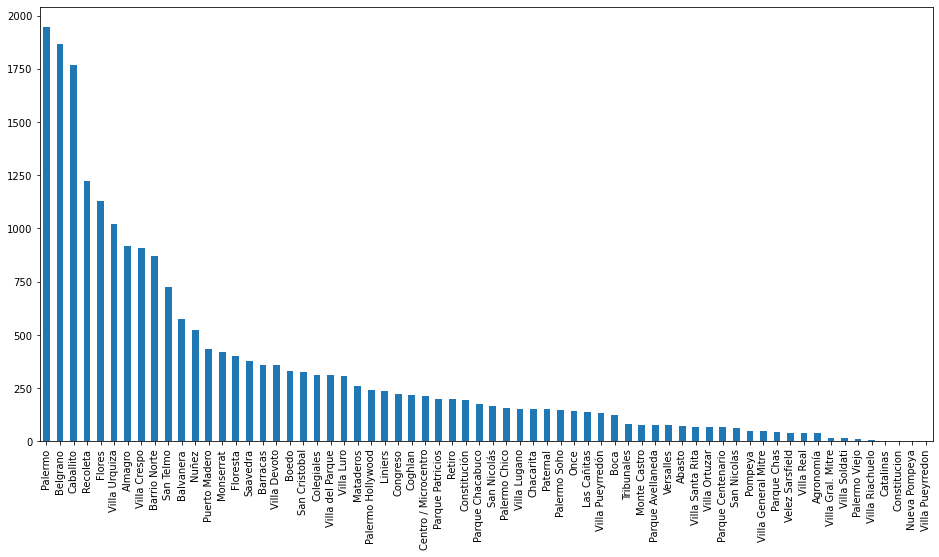

In [138]:
df_caba_barrios_calculados.place_name.value_counts().plot(kind="bar",figsize = (16,8))